In [ ]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 69.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/CropYieldHistoric.csv")

In [ ]:
df.head(5)

,Year,Area,Production,Temparature,Rain,Yield (ton/ha),Crop
0,1998-99,3526.67,10551.9,25.98,199.04,NaN,Boro
1,1973-74,3107.90,2801.0,24.82,200.52,0.90,Aus
2,2011-12,4810.00,18783.0,25.23,214.26,NaN,Boro
3,1990-91,5775.30,9167.0,25.27,210.09,1.59,Aman
4,1977-78,1093.70,2239.0,24.69,184.45,NaN,Boro


In [ ]:
df.isnull().value_counts()

Year   Area   Production  Temparature  Rain   Yield (ton/ha)  Crop 
False  False  False       False        False  False           False    98
                                              True            False    49
Name: count, dtype: int64

In [ ]:
for col in df.columns:
    if df[col].dtype== 'object':
        df[col] = df[col].fillna("Missing")
    else:
        df[col] = df[col].fillna(df[col].median())

In [ ]:
df.isnull().value_counts()

,,,,,,,count
Year,Area,Production,Temparature,Rain,Yield (ton/ha),Crop,
False,False,False,False,False,False,False,147


In [ ]:
label_encoders = {}

for col in df.select_dtypes(include= ['object']).columns:
    le= LabelEncoder()
    df[col]= le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
df.head(5) #boro=2 aus=1 aman=0

,Year,Area,Production,Temparature,Rain,Yield (ton/ha),Crop
0,27,3526.67,10551.9,25.98,199.04,1.46,2
1,2,3107.90,2801.0,24.82,200.52,0.90,1
2,40,4810.00,18783.0,25.23,214.26,1.46,2
3,19,5775.30,9167.0,25.27,210.09,1.59,0
4,6,1093.70,2239.0,24.69,184.45,1.46,2


In [ ]:
df['Production'].max()

20388.5

In [ ]:
X = df.drop(['Production'], axis=1)
y = df["Production"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
lr = LinearRegression()
sfs = SFS(lr,
          k_features='best',
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

sfs = sfs.fit(X_train, y_train)
selected_features = list(sfs.k_feature_names_)
print("\nSelected Features:", selected_features)



Selected Features: ['Year', 'Area', 'Yield (ton/ha)', 'Crop']


In [ ]:
lr.fit(X_train[selected_features], y_train)

LinearRegression()

In [ ]:
X = df[['Year', 'Rain', 'Temparature']]   # use your feature columns
y = df['Production']                      # target column

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predictions ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# --- Metrics ---
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print("📊 Model Performance on Test Data:")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")

📊 Model Performance on Test Data:
MAE   : 3601.7420
MSE   : 21196460.7678
RMSE  : 4603.9614
R²    : 0.1252


In [ ]:
def predict_future(year, rain, temp):
    # Keep the same column order as training
    future_input = pd.DataFrame([[year, rain, temp]],
                                columns=['Year', 'Rain', 'Temparature'])
    prediction = model.predict(future_input)
    return prediction[0]

In [ ]:
future_pred = predict_future(2022, 80, 35)  # year=2026, rain=120, temp=30
print(f"\n🔮 Predicted production for 2026: {future_pred:.2f}")


🔮 Predicted production for 2026: 419029.61


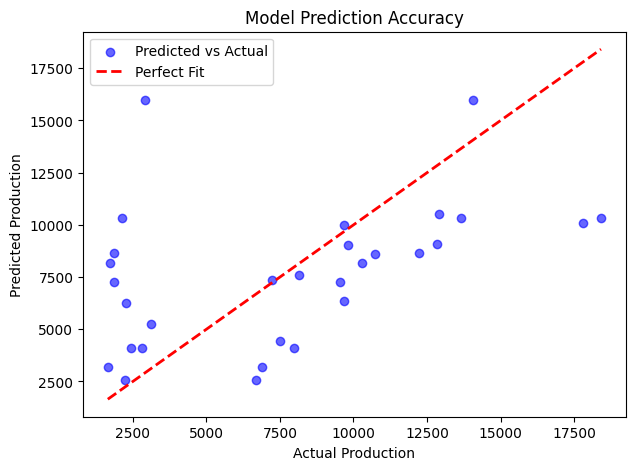

In [ ]:
def ui_predictor():
    plt.figure(figsize=(7,5))
    # scatter actual vs predicted
    plt.scatter(y_test, y_test_pred, color="blue", alpha=0.6, label="Predicted vs Actual")
    # perfect prediction line
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r--", lw=2, label="Perfect Fit")
    plt.xlabel("Actual Production")
    plt.ylabel("Predicted Production")
    plt.title("Model Prediction Accuracy")
    plt.legend()
    plt.show()

ui_predictor()

In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div(style={'font-family': 'Arial', 'margin': '30px','color': 'white'}, children=[
    html.H1("📊 Production Prediction Dashboard", style={'text-align': 'center', 'color': 'white'}),

    html.Div([
        html.Label("Year:"),
        dcc.Input(id="year-input", type="number", value=2026, min=2000, max=2035, step=1),

        html.Label("Rain:"),
        dcc.Input(id="rain-input", type="number", value=120, min=0, max=300, step=5),

        html.Label("Temparature:"),
        dcc.Input(id="temp-input", type="number", value=30, min=0, max=50, step=1),
    ], style={'display': 'flex', 'gap': '20px', 'margin': '20px 0'}),

    html.Div(id="prediction-output", style={'font-size': '20px', 'margin': '20px 0','color': 'white'}),

    dcc.Graph(id="scatter-plot"),
])

@app.callback(
    Output("prediction-output", "children"),
    Output("scatter-plot", "figure"),
    Input("year-input", "value"),
    Input("rain-input", "value"),
    Input("temp-input", "value")
)
def update_prediction(year, rain, temp):
    if year is None or rain is None or temp is None:
        return "⚠️ Please enter valid inputs", {}

    # ✅ Correct column names (same as training)
    future_input = pd.DataFrame([[year, rain, temp]],
                                columns=['Year', 'Rain', 'Temparature'])
    future_pred = model.predict(future_input)[0]

    # Scatter Plot (Actual vs Predicted)
    fig = px.scatter(
        x=y_test, y=y_test_pred,
        labels={'x': 'Actual Production', 'y': 'Predicted Production'},
        title="Actual vs Predicted Production"
    )

    # Perfect Fit Line
    fig.add_shape(
        type="line",
        x0=y_test.min(), y0=y_test.min(),
        x1=y_test.max(), y1=y_test.max(),
        line=dict(color="red", dash="dash")
    )

    # Future Prediction Point
    fig.add_scatter(
        x=[y_test.max()], y=[future_pred],
        mode="markers+text",
        text=[f"Future: {future_pred:.2f}"],
        textposition="top center",
        marker=dict(size=12, color="green"),
        name="Future Prediction"
    )

    return f"🔮 Predicted Production for {year}: {future_pred:.2f}", fig

# --- Run App ---
if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)

<IPython.core.display.Javascript object>